In [1]:
import torch
from torch.utils.data import DataLoader
from utils import global_stats, signal_normalization
from data.data.dataloader import CWRUDataset, custom_collate_fn

size = 2**14 # 16384
recovery = 0.95 # 95% overlap between patches

complete_dataset = CWRUDataset(
    fault_filter=['normal', 'inner', 'outer'],
    window_size=size,
    stride=int(size * (1 - recovery)))

mean, std = global_stats(complete_dataset)

normal_dataset = CWRUDataset(
    fault_filter=['normal'],
    window_size=size,
    stride=int(size * (1 - recovery)))

inner_dataset = CWRUDataset(
    fault_filter=['inner'],
    window_size=size,
    stride=int(size * (1 - recovery)))

outer_dataset = CWRUDataset(
    fault_filter=['outer'],
    window_size=size,
    stride=int(size * (1 - recovery)))

ball_dataset = CWRUDataset(
    fault_filter=['ball'],
    window_size=size,
    stride=int(size * (1 - recovery)))

normal_loader = DataLoader(normal_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
inner_loader = DataLoader(inner_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
outer_loader = DataLoader(outer_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
ball_loader = DataLoader(ball_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [4]:
import numpy as np
from tqdm import tqdm

def covariance_matrix(x):
    x = x - np.mean(x,axis=1,keepdims=True)
    b,n = x.shape
    cov = (x.T @ x)/n
    return cov

def covariance_loss(x,y):
    C_true = covariance_matrix(x)
    C_pred = covariance_matrix(y)
    return np.linalg.norm(C_true - C_pred)**2

def mae(x,y):
    return np.mean(np.abs(x-y), axis=-1)

def mse(x,y):
    return np.mean((x-y)**2, axis=-1)

def cosinus_similarity(x,y):
    numerator = np.sum(x*y, axis=-1)
    denominator = np.sqrt(np.sum(x**2, axis=-1)) * np.sqrt(np.sum(y**2, axis=1))
    return 1 - (numerator / denominator)

def inference_model(model,device,data_loader, mean, std):
    embedding_token = list()
    encoded_token = list()
    decoded_token = list()
    for batch in tqdm(data_loader):

        signals_reduce = torch.stack(batch['vibration_fft_reduce']).unsqueeze(1).to(device)  # (batch_size, 1, signal_length)
        signals_complete = torch.stack(batch['vibration_fft_complete']).unsqueeze(1).to(device)  # (batch_size, 1, signal_length)

        signals_reduce = signal_normalization(signals_reduce, mean, std)  # (batch_size, 1, signal_length)
        signals_complete = signal_normalization(signals_complete, mean, std)  # (batch_size, 1, signal_length)
        
        with torch.no_grad():
            patch_emb, encoded_tokens, decoded_tokens = model(signals_reduce)  # (batch_size, 1, signal_length)

        signals_predict = decoded_tokens
        signals_complete = signals_complete.squeeze(1)

        signals_predict = signals_predict.cpu().numpy()
        signals_complete = signals_complete.cpu().numpy()

        b, s = signals_predict.shape
        signals_complete = signals_complete[:,:s]

        # loss_cosinus = cosinus_similarity(signals_complete, signals_predict)
        # loss_mse = mse(signals_complete, signals_predict)
        # loss_mae = mae(signals_complete, signals_predict)
        # loss_cov = covariance_loss(signals_complete, signals_predict)
        
        embedding_token.append(patch_emb)
        encoded_token.append(encoded_tokens[:,0,:])
        decoded_token.append(decoded_tokens)

    embedding_token = torch.cat(embedding_token, dim=0)
    encoded_token = torch.cat(encoded_token, dim=0)
    decoded_token = torch.cat(decoded_token, dim=0)

    return embedding_token, encoded_token, decoded_token

In [ ]:
from model import ViTAutoencoder
import numpy as np

# Load the model for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get size of fft
size_fft = complete_dataset[0]['vibration_fft_complete'].shape[-1] # 8193

# Load the model for inference
# model = ViT(serie_len=size_fft).to(device)
model = ViTAutoencoder(encoder_dim = 2**10, #
                       decoder_dim = 2**11, 
                       serie_len = size_fft,
                       patch_size = 64,
                       n_layers = 2,
                       heads = 4,
                       dropout=0.1).to(device)


model.load_state_dict(torch.load('models/model_v2.pth'))
model.eval()

mean = mean.to(device)
std = std.to(device)

token = list()
labels = list()
for label,loader in zip(['normal'], [normal_loader]):
    print(label)
    embedding_token, encoded_token, decoded_token = inference_model(model, device, loader, mean, std)
    token.append(encoded_token)
    labels.append([label for _ in range(encoded_token.shape[0])])

labels = np.concatenate(labels)
encoded_token = torch.cat(token, dim=0)



normal


100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


In [12]:
import plotly.graph_objects as go

# Sélectionner un index pour comparer un signal spécifique
index = 10

# Extraire les signaux réels et prédits
signal_reel = complete_dataset[index]['vibration_fft_complete'].cpu().numpy()
signal_predit = decoded_token[index].cpu().numpy() * std.cpu().numpy()[:8192] + mean.cpu().numpy()[:8192]

# Créer une figure interactive
fig = go.Figure()

# Ajouter le signal réel
fig.add_trace(go.Scatter(
    y=signal_reel,
    mode='lines',
    name='Signal Réel'
))

# Ajouter le signal prédit
fig.add_trace(go.Scatter(
    y=signal_predit,
    mode='lines',
    name='Signal Prédit'
))

# Ajouter un titre et des étiquettes
fig.update_layout(
    title='Comparaison du Signal Réel et Prédit',
    xaxis_title='Index',
    yaxis_title='Amplitude',
    legend=dict(x=0, y=1)
)

# Sauvegarder en format HTML
fig.write_html('signal_comparison.html', include_plotlyjs='cdn')

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(encoded_token.cpu().numpy())
df.index = labels

normalize_df= (df - df.mean())/ df.std()

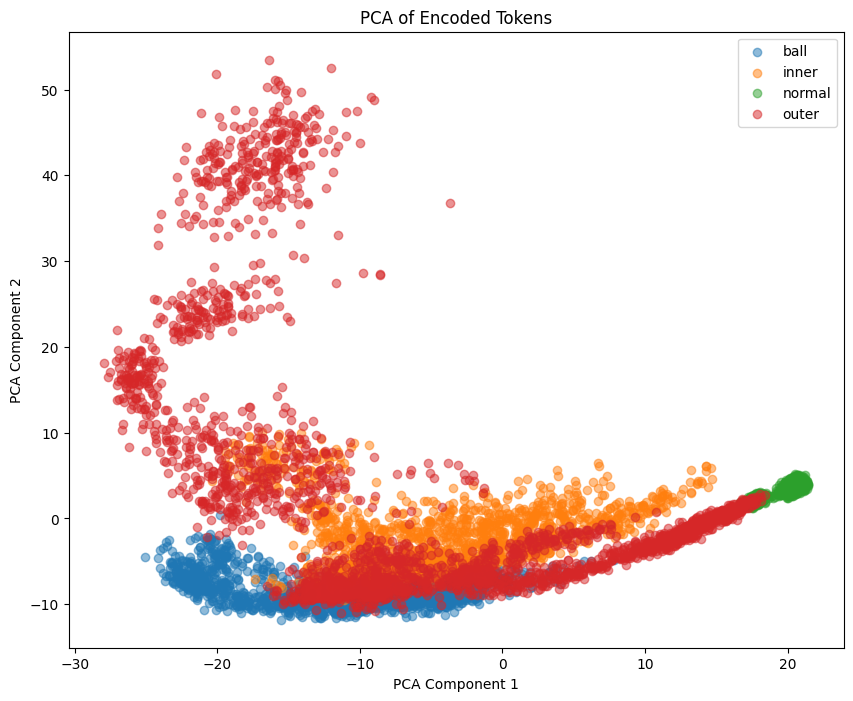

In [34]:
from sklearn.decomposition import PCA
import numpy as np

colors = ['red', 'green', 'blue', 'yellow'] 

pca = PCA(n_components=0.95)  

pca_scores = pca.fit_transform(normalize_df.values)
pca__scores = pd.DataFrame(pca_scores)
pca__scores.index = labels

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(pca__scores.loc[label][0], pca__scores.loc[label][1], label=label, alpha=0.5)
plt.title('PCA of Encoded Tokens')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()


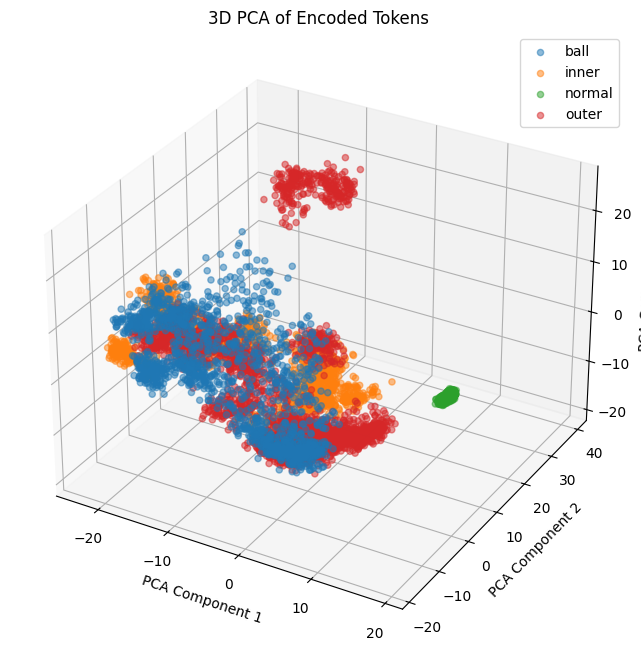

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(labels):
    ax.scatter(
        pca__scores.loc[label][0],
        pca__scores.loc[label][1],
        pca__scores.loc[label][2],
        label=label,
        alpha=0.5
    )

ax.set_title('3D PCA of Encoded Tokens')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()

In [36]:
import pandas as pd

import plotly.express as px

# Créer un DataFrame pour les données PCA en 3D
pca_3d = pd.DataFrame({
    'PCA1': pca__scores[0],
    'PCA2': pca__scores[1],
    'PCA3': pca__scores[2],
    'Label': labels
})

# Créer un graphique 3D interactif
fig = px.scatter_3d(
    pca_3d,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Label',
    title='3D PCA Interactive Plot',
    opacity=0.7
)

# Afficher le graphique
# fig.show()

# sauvegarder en format html
fig.write_html('tsne.html', include_plotlyjs='cdn')

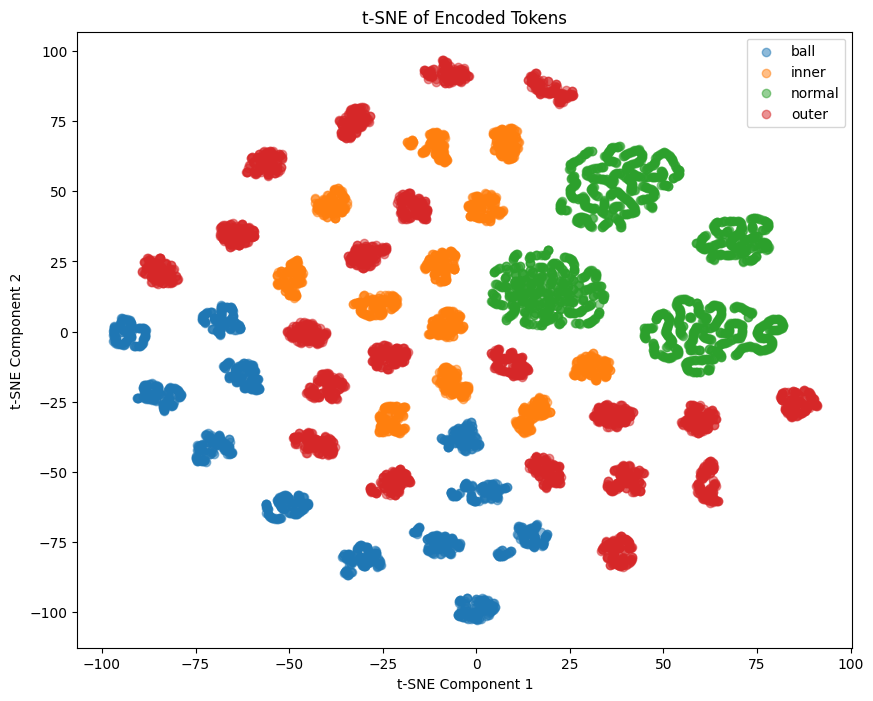

In [35]:
from sklearn.manifold import TSNE

# Réduire la dimensionnalité à 2D
tsne = TSNE(n_components=2)
projected_embeddings = tsne.fit_transform(normalize_df.values)

projected_embeddings = pd.DataFrame(projected_embeddings)
projected_embeddings.index = labels

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(projected_embeddings.loc[label][0], projected_embeddings.loc[label][1], label=label, alpha=0.5)
plt.title('t-SNE of Encoded Tokens')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.savefig('tsne.png', dpi=300, bbox_inches='tight')